In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time

In [2]:
# BITFINEX

def candles(symbol: str, timeFrame: str, section: str='hist', limit: int=100, sort: int=1):
    url = f'https://api.bitfinex.com/v2/candles/trade:{timeFrame}:{symbol}/{section}'
    option = {'limit': limit, 'sort': sort} 
    r = requests.get(url, params = option)
    return r.json()

res = candles('tETHUSD', '1D', 'hist', 500, 1)

chart = pd.DataFrame(res)

name = ['mts', 'open', 'close', 'high', 'low', 'volume']
chart.columns = name

In [22]:
#POLONIEX

period = '86400' # 300, 900, 1800, 7200, 14400, 86400
pair = 'USDT_ETH'
#start = '1451606400' #jan, 2016
start = '1483228800' #jan, 2017
#start = '1514764800' #jan, 2018
end = '9999999999'


URL = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'.format(pair, start, end, period)
chart = pd.read_json(URL)

In [23]:
chart['ema12'] = chart['close'].ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
chart['ema26'] = chart['close'].ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
chart['macd'] = chart['ema12'] - chart['ema26']
chart['signal'] = chart['macd'].ewm(span=9,min_periods=0,adjust=True,ignore_na=False).mean()

# chart['sma50'] = chart['close'].rolling(window=50,center=False).mean()
# chart['sma40'] = chart['close'].rolling(window=40,center=False).mean()
# chart['sma30'] = chart['close'].rolling(window=30,center=False).mean()

# chart['ema40'] = chart['close'].ewm(span=30,min_periods=0,adjust=True,ignore_na=False).mean()
# chart['ema30'] = chart['close'].ewm(span=30,min_periods=0,adjust=True,ignore_na=False).mean()


chart['ema20'] = chart['close'].ewm(span=20,min_periods=0,adjust=True,ignore_na=False).mean()
chart['sma30'] = chart['close'].rolling(window=30,center=False).mean()
chart['trend'] = chart['ema20'] - chart['sma30']
chart['diff'] = chart['macd'] - chart['signal']


chart = chart[29:]

chart.tail()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,ema12,ema26,macd,signal,ema20,sma30,trend,diff
800,133.600546,2019-03-12,135.231143,128.100000,133.050641,3757.183286,4.971364e+05,132.316251,134.539849,133.063973,1.475876,2.388161,133.951812,134.555867,-0.604054,-0.912286
801,131.927212,2019-03-13,134.130000,130.735698,133.601000,1696.619623,2.245949e+05,132.377904,134.137905,132.979769,1.158136,2.142156,133.758993,134.927300,-1.168306,-0.984020
802,132.204843,2019-03-14,135.301842,129.286823,131.750000,4604.392082,6.073278e+05,131.901845,133.840510,132.922367,0.918144,1.897354,133.610979,135.250600,-1.639621,-0.979210
803,136.388000,2019-03-15,137.707707,132.278205,132.309844,11986.486236,1.611366e+06,134.431882,134.232432,133.179080,1.053352,1.728553,133.875457,135.728768,-1.853311,-0.675202
804,139.950672,2019-03-16,144.300000,136.591658,136.638493,8637.472449,1.215219e+06,140.691536,135.112161,133.680680,1.431482,1.669139,134.454049,136.382124,-1.928075,-0.237657


In [26]:
size = chart.date.count()
order = 0 # amount
asset = 1
history = [1]
growth = []

method = 0

fee = 0.999

for i in range(size):
    entry = chart.iloc[i]
    price = entry['open']
    
    if method == 1:
        amount = (asset / price) * fee
        order = amount
        asset = 0
        method = 0

    if method == -1:
        asset += (order * price) * fee
#         gain = (asset / history[-1])
        history.append(asset)
#         growth.append(gain)
        order = 0
        method = 0

    else:
        if entry['trend'] < 0:
            if order:
                method = -1
        
        if entry['trend'] > 0:
            if not order:
                if entry['diff'] > 0:
                    method = 1
            else:
                if entry['diff'] < 0:
                    method = -1

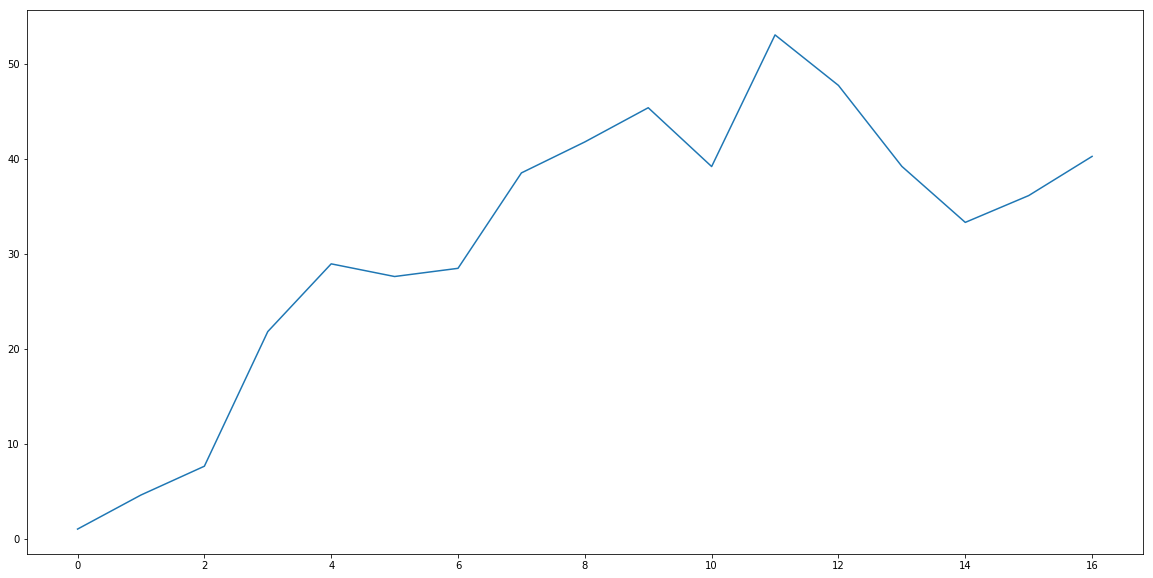

In [27]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.plot(history)
plt.show()